In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["NUMEXPR_MAX_THREADS"] = "8"

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [49]:
import sys
import time
import numpy as np
import pandas as pd
from typing import Dict, Any
from tqdm.notebook import tqdm
from dataclasses import dataclass

sys.path.append('../src/')
from configs import *
from training import *
from plotting import *
from feature_selection import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
rcParams.update(fig_params)

import scipy.stats as stats
from scipy.stats import loguniform
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer, recall_score, confusion_matrix
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV


from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

sensitivity_scorer = make_scorer(recall_score, pos_label=1)
specificity_scorer = make_scorer(specificity_score)

scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'sensitivity': sensitivity_scorer,
    'specificity': specificity_scorer,
    'matthews_corrcoef': 'matthews_corrcoef'
}

to_optimize = 'matthews_corrcoef'
n_iter = 100
n_jobs = 64
random_state = 0
verbose = 0
error_score = 'raise'

## Load data

In [4]:
feature_list = ['physicochemical',
                'AAC',
                'CKSAAP type 1',
                'TPC type 1',
                'DPC type 1',
                'DDE',
                'GAAC',
                'CKSAAGP type 1',
                'GDPC type 1',
                'GTPC type 1',
                'Moran',
                'Geary',
                'NMBroto',
                'CTDC',
                'CTDT',
                'CTDD',
                'CTriad',
                'KSCTriad',
                'SOCNumber',
                'QSOrder',
                'PAAC',
                'APAAC',
                'ASDC',
                'AC',
                'CC',
                'ACC',
                'EAAC',
                'EGAAC',
                'AAIndex',
                'BLOSUM62',
                'ZScale'
               ]

comb, features = load_dataset(feature_list=feature_list, dataset_name='comb', features_folder=os.path.join('..', 'features'))

## Train-test split

In [5]:
train = comb[comb.Dataset=='train'].copy()
test  = comb[comb.Dataset=='test'].copy()

## Cross-validation strategy

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv = list(cv.split(train[features], train[TARGET]))

## Common pipeline

In [7]:
preprocessor = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

## Storer object

In [8]:
@dataclass
class HPOResult:
    model_name: str
    best_params: Dict[str, Any]
    best_score: float
    cv_results: pd.DataFrame
    cv_scores: np.ndarray
    search_time: float

results: Dict[str, HPOResult] = {}

## K-nn classifier

In [9]:
%%time
model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', KNeighborsClassifier(n_jobs=8))
        ])


cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} without HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef without HPO:
0.000 ± 0.000
CPU times: user 47.4 ms, sys: 194 ms, total: 241 ms
Wall time: 2.81 s


In [10]:
%%time
param_distributions = {
    'model__n_neighbors': [5, 10, 15, 25, 50, 100, 250, 500],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],
    'model__p': [1, 2],
}

search_cv = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=to_optimize,
    n_jobs=n_jobs,
    cv=cv,
    random_state=random_state,
    verbose=verbose,
    error_score=error_score
)
start_time = time.time()
search_cv.fit(train[features], train[TARGET])
end_time = time.time()

CPU times: user 4.35 s, sys: 1.59 s, total: 5.95 s
Wall time: 25.1 s


In [11]:
%%time

model.set_params(**search_cv.best_params_)

cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} with HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef with HPO:
0.153 ± 0.022
CPU times: user 68.9 ms, sys: 191 ms, total: 260 ms
Wall time: 4.81 s


In [12]:
results['knn'] = HPOResult(
    model_name='K-Nearest Neighbors',
    best_params=search_cv.best_params_,
    best_score=search_cv.best_score_,
    cv_results=search_cv.cv_results_,
    search_time=end_time - start_time,
    cv_scores=cv_results
)

## Logistic Regression L2

In [13]:
%%time
model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', LogisticRegression(penalty='l2', solver='lbfgs', random_state=random_state, n_jobs=8, max_iter=1000))
        ])


cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} without HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef without HPO:
0.722 ± 0.024
CPU times: user 39 ms, sys: 101 ms, total: 140 ms
Wall time: 2.16 s


In [14]:
%%time
param_grid = {
    'model__C': np.logspace(-5, 3, num=n_iter),
}

search_cv = GridSearchCV(
    model,
    param_grid,
    scoring=to_optimize,
    n_jobs=n_jobs,
    cv=cv,
    verbose=verbose,
    error_score=error_score
)
start_time = time.time()
search_cv.fit(train[features], train[TARGET])
end_time = time.time()

CPU times: user 4.87 s, sys: 2.08 s, total: 6.95 s
Wall time: 24.8 s


In [15]:
%%time

model.set_params(**search_cv.best_params_)

cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} with HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef with HPO:
0.729 ± 0.029
CPU times: user 55.1 ms, sys: 172 ms, total: 227 ms
Wall time: 3.05 s


In [16]:
results['logistic_l2'] = HPOResult(
    model_name='Logistic Regression (L2)',
    best_params=search_cv.best_params_,
    best_score=search_cv.best_score_,
    cv_results=search_cv.cv_results_,
    search_time=end_time - start_time,
    cv_scores=cv_results
)

## Logistic Regression L1

In [17]:
%%time
model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', LogisticRegression(penalty='l1', solver='liblinear', random_state=random_state, max_iter=1000))
        ])


cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} without HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef without HPO:
0.688 ± 0.035
CPU times: user 41.2 ms, sys: 91.4 ms, total: 133 ms
Wall time: 2.83 s


In [18]:
%%time
param_grid = {
    'model__C': np.logspace(-5, 3, num=n_iter),
}

search_cv = GridSearchCV(
    model,
    param_grid,
    scoring=to_optimize,
    n_jobs=n_jobs,
    cv=cv,
    verbose=verbose,
    error_score=error_score
)
start_time = time.time()
search_cv.fit(train[features], train[TARGET])
end_time = time.time()

CPU times: user 4.93 s, sys: 1.78 s, total: 6.71 s
Wall time: 25.6 s


In [19]:
%%time

model.set_params(**search_cv.best_params_)

cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} with HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef with HPO:
0.710 ± 0.046
CPU times: user 83.3 ms, sys: 172 ms, total: 255 ms
Wall time: 3.7 s


In [20]:
results['logistic_l1'] = HPOResult(
    model_name='Logistic Regression (L1)',
    best_params=search_cv.best_params_,
    best_score=search_cv.best_score_,
    cv_results=search_cv.cv_results_,
    search_time=end_time - start_time,
    cv_scores=cv_results
)

## Support vector machine

In [21]:
%%time
model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', SVC(random_state=random_state))
        ])


cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} without HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef without HPO:
0.584 ± 0.042
CPU times: user 116 ms, sys: 158 ms, total: 274 ms
Wall time: 35.5 s


In [22]:
%%time

param_distributions = {
    'model__C': np.logspace(-2, 3, 10),
    'model__gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 10)),
    'model__kernel': ['rbf', 'poly', 'sigmoid'],
    'model__degree': [2, 3, 4],
}

search_cv = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=to_optimize,
    n_jobs=n_jobs,
    cv=cv,
    random_state=random_state,
    verbose=verbose,
    error_score=error_score
)
start_time = time.time()
search_cv.fit(train[features], train[TARGET])
end_time = time.time()

CPU times: user 23.6 s, sys: 21.4 s, total: 45 s
Wall time: 2min 49s


In [23]:
%%time

model.set_params(**search_cv.best_params_)

cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} with HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef with HPO:
0.694 ± 0.029
CPU times: user 122 ms, sys: 547 ms, total: 669 ms
Wall time: 10 s


In [24]:
results['svm'] = HPOResult(
    model_name='Support Vector Machine',
    best_params=search_cv.best_params_,
    best_score=search_cv.best_score_,
    cv_results=search_cv.cv_results_,
    search_time=end_time - start_time,
    cv_scores=cv_results
)

## MLP

In [25]:
%%time
model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', MLPClassifier(random_state=random_state, max_iter=1000, early_stopping=True))
        ])


cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} without HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef without HPO:
0.645 ± 0.039
CPU times: user 38.2 ms, sys: 107 ms, total: 146 ms
Wall time: 5.36 s


In [26]:
%%time

param_distributions = {
    'model__hidden_layer_sizes': [
        (50,), (100,), (200,),
        (100, 50), (200, 100), (300, 150),
        (100, 50, 25), (200, 100, 50), (300, 200, 100),
    ],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': stats.loguniform(1e-5, 1e-1),
    'model__learning_rate': ['constant', 'adaptive', 'invscaling'],
    'model__learning_rate_init': stats.loguniform(1e-4, 1e-1),
}

search_cv = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=to_optimize,
    n_jobs=n_jobs,
    cv=cv,
    random_state=random_state,
    verbose=verbose,
    error_score=error_score
)
start_time = time.time()
search_cv.fit(train[features], train[TARGET])
end_time = time.time()

CPU times: user 1min 9s, sys: 4min 12s, total: 5min 22s
Wall time: 1min 42s


In [27]:
%%time

model.set_params(**search_cv.best_params_)

cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} with HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef with HPO:
0.728 ± 0.025
CPU times: user 331 ms, sys: 1.53 s, total: 1.86 s
Wall time: 12.4 s


In [28]:
results['mlp'] = HPOResult(
    model_name='Multi-Layer Perceptron',
    best_params=search_cv.best_params_,
    best_score=search_cv.best_score_,
    cv_results=search_cv.cv_results_,
    search_time=end_time - start_time,
    cv_scores=cv_results
)

## Random forest

In [29]:
%%time
model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestClassifier(n_jobs=8, random_state=random_state))
        ])


cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} without HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef without HPO:
0.747 ± 0.024
CPU times: user 42.2 ms, sys: 98.5 ms, total: 141 ms
Wall time: 2.29 s


In [30]:
%%time

param_distributions = {
    "model__max_features": ['sqrt', 'log2'] + list(np.arange(0.2, 1.0, 0.1)),
    "model__max_leaf_nodes": [10, 100, 1000, None],
    "model__min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
}

search_cv = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=to_optimize,
    n_jobs=n_jobs,
    cv=cv,
    random_state=random_state,
    verbose=verbose,
    error_score=error_score
)
start_time = time.time()
search_cv.fit(train[features], train[TARGET])
end_time = time.time()

CPU times: user 6.25 s, sys: 1.78 s, total: 8.02 s
Wall time: 1min 2s


In [31]:
%%time

model.set_params(**search_cv.best_params_)

cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} with HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef with HPO:
0.765 ± 0.034
CPU times: user 76.2 ms, sys: 192 ms, total: 268 ms
Wall time: 3.52 s


In [32]:
results['random_forest'] = HPOResult(
    model_name='Random Forest',
    best_params=search_cv.best_params_,
    best_score=search_cv.best_score_,
    cv_results=search_cv.cv_results_,
    search_time=end_time - start_time,
    cv_scores=cv_results
)

## LightGBM

In [33]:
%%time
model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', LGBMClassifier(n_jobs=8, random_state=random_state, verbosity=-1))
        ])


cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} without HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ut

Matthews_corrcoef without HPO:
0.737 ± 0.045
CPU times: user 47.5 ms, sys: 106 ms, total: 153 ms
Wall time: 7.01 s


In [34]:
%%time

param_distributions = {
    'model__n_estimators': [3, 10, 30, 100, 200, 300],
    'model__num_leaves': [2, 4, 8, 12, 16, 24, 31, 32, 48, 64, 96, 128],
    'model__learning_rate': loguniform(0.01, 1),
    'model__feature_fraction': list(np.arange(0.2, 1.0, 0.1)),
    # 'model__bagging_fraction': list(np.arange(0.7, 1.0, 0.1)),
    # 'model__bagging_freq': [0, 1],
}

search_cv = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=to_optimize,
    n_jobs=n_jobs,
    cv=cv,
    random_state=random_state,
    verbose=verbose,
    error_score=error_score
)
start_time = time.time()
search_cv.fit(train[features], train[TARGET])
end_time = time.time()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ut

CPU times: user 17.2 s, sys: 3.69 s, total: 20.9 s
Wall time: 57.7 s


In [35]:
%%time

model.set_params(**search_cv.best_params_)

cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} with HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ut

Matthews_corrcoef with HPO:
0.767 ± 0.023
CPU times: user 88 ms, sys: 238 ms, total: 326 ms
Wall time: 6.44 s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [36]:
results['lightgbm'] = HPOResult(
    model_name='LightGBM',
    best_params=search_cv.best_params_,
    best_score=search_cv.best_score_,
    cv_results=search_cv.cv_results_,
    search_time=end_time - start_time,
    cv_scores=cv_results
)

## HistGradientBoosting

In [37]:
%%time
model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', HistGradientBoostingClassifier(random_state=random_state))
        ])


cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} without HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef without HPO:
0.748 ± 0.045
CPU times: user 156 ms, sys: 200 ms, total: 356 ms
Wall time: 31.1 s


In [38]:
%%time

param_distributions = {
    'model__max_iter': [3, 10, 30, 100, 200, 300],
    'model__max_leaf_nodes': [2, 4, 8, 12, 16, 24, 31, 32, 48, 64, 96, 128],
    'model__learning_rate': loguniform(0.01, 1),
    'model__max_features': list(np.arange(0.2, 1.0, 0.1)),
    # 'model__bagging_fraction': list(np.arange(0.7, 1.0, 0.1)),
    # 'model__bagging_freq': [0, 1],
}

search_cv = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=to_optimize,
    n_jobs=n_jobs,
    cv=cv,
    random_state=random_state,
    verbose=verbose,
    error_score=error_score
)
start_time = time.time()
search_cv.fit(train[features], train[TARGET])
end_time = time.time()

CPU times: user 2min 43s, sys: 37.6 s, total: 3min 21s
Wall time: 8min 30s


In [39]:
%%time

model.set_params(**search_cv.best_params_)

cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} with HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef with HPO:
0.762 ± 0.032
CPU times: user 210 ms, sys: 364 ms, total: 574 ms
Wall time: 33.8 s


In [40]:
results['histgb'] = HPOResult(
    model_name='Histogram Gradient Boosting',
    best_params=search_cv.best_params_,
    best_score=search_cv.best_score_,
    cv_results=search_cv.cv_results_,
    search_time=end_time - start_time,
    cv_scores=cv_results
)

## XGBoost

In [41]:
%%time
model = Pipeline([
            ('preprocessor', preprocessor),
            ('model', XGBClassifier(n_jobs=8, random_state=random_state, tree_method='hist'))
        ])


cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} without HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef without HPO:
0.739 ± 0.045
CPU times: user 63 ms, sys: 129 ms, total: 192 ms
Wall time: 10 s


In [42]:
%%time

param_distributions = {
    'model__n_estimators': [3, 10, 30, 100, 200, 300],
    'model__max_depth': [3, 5, 6, 7, 9, 11],
    'model__learning_rate': loguniform(0.01, 1),
    'model__colsample_bytree': list(np.arange(0.2, 1.0, 0.1)),
    # 'model__bagging_fraction': list(np.arange(0.7, 1.0, 0.1)),
    # 'model__bagging_freq': [0, 1],
}

search_cv = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=to_optimize,
    n_jobs=n_jobs-14,
    cv=cv,
    random_state=random_state,
    verbose=verbose,
    error_score=error_score
)
start_time = time.time()
search_cv.fit(train[features], train[TARGET])
end_time = time.time()

CPU times: user 2min 23s, sys: 2.83 s, total: 2min 25s
Wall time: 2min 35s


In [43]:
%%time

model.set_params(**search_cv.best_params_)

cv_results = cross_validate(model, train[features], train[TARGET], scoring=scoring, cv=cv, n_jobs=5)
cv_results_df = pd.DataFrame(cv_results)
print(
    f"{to_optimize.capitalize()} with HPO:\n"
    f"{cv_results_df[f'test_{to_optimize}'].mean():.3f} ± "
    f"{cv_results_df[f'test_{to_optimize}'].std():.3f}"
)

Matthews_corrcoef with HPO:
0.762 ± 0.030
CPU times: user 119 ms, sys: 327 ms, total: 446 ms
Wall time: 29.7 s


In [44]:
results['xgboost'] = HPOResult(
    model_name='XGBoost',
    best_params=search_cv.best_params_,
    best_score=search_cv.best_score_,
    cv_results=search_cv.cv_results_,
    search_time=end_time - start_time,
    cv_scores=cv_results
)

## Saving

In [45]:
import joblib
for name, result in results.items():
    joblib.dump(result, f'hpo_results_{name}.pkl')

## Analysis

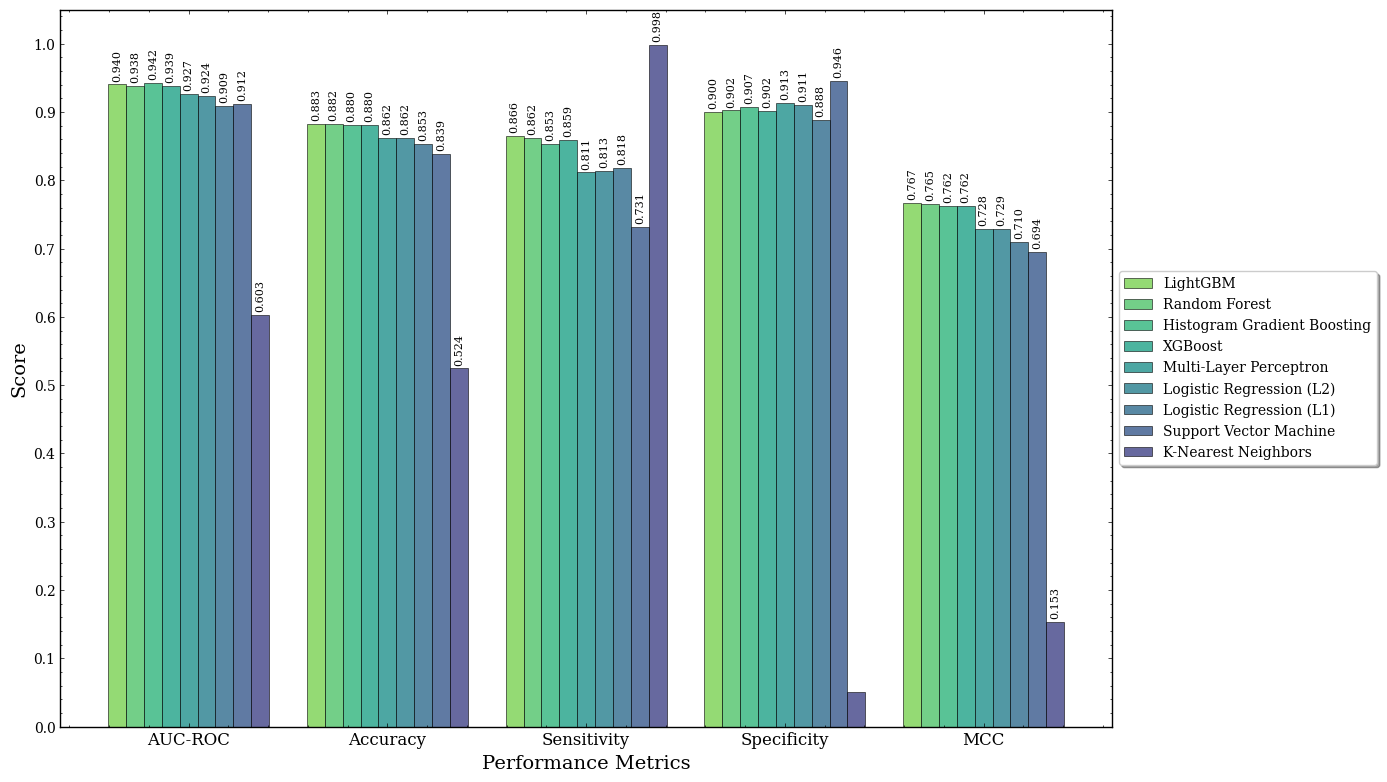

In [48]:
fig, ax = create_model_performance_summary(results)
#plt.savefig('model_performance_summary.png', dpi=300, bbox_inches='tight')

In [50]:
summary_table = create_results_table(results)
print(summary_table.to_string(index=False))

                      Model Best MCC Search Time (s)    CV Roc Auc   CV Accuracy CV Sensitivity CV Specificity CV Matthews Corrcoef
                   LightGBM   0.7670           57.70 0.940 ± 0.008 0.883 ± 0.010  0.866 ± 0.021  0.900 ± 0.018        0.767 ± 0.020
              Random Forest   0.7652           62.49 0.938 ± 0.008 0.882 ± 0.015  0.862 ± 0.017  0.902 ± 0.020        0.765 ± 0.030
Histogram Gradient Boosting   0.7623          510.03 0.942 ± 0.006 0.880 ± 0.014  0.853 ± 0.018  0.907 ± 0.024        0.762 ± 0.029
                    XGBoost   0.7623          155.13 0.939 ± 0.008 0.880 ± 0.013  0.859 ± 0.015  0.902 ± 0.031        0.762 ± 0.027
   Logistic Regression (L2)   0.7286           24.78 0.924 ± 0.008 0.862 ± 0.014  0.813 ± 0.033  0.911 ± 0.024        0.729 ± 0.026
     Multi-Layer Perceptron   0.7285          102.16 0.927 ± 0.009 0.862 ± 0.012  0.811 ± 0.031  0.913 ± 0.015        0.728 ± 0.023
   Logistic Regression (L1)   0.7099           25.60 0.909 ± 0.010 0.853 ± 0